Data Cleaning

In [2]:
import pandas as pd
import os

# Read data file
df = pd.read_csv("https://raw.githubusercontent.com/NumanESchulich/SchulichDataScience/main/AI%20Fundamentals%20(MMAI%205000S)/AI-Human%20Pew%20Data.csv")

# Define the SMALG columns & Demographic Columns
smalg_columns = ['SMALG2_W99', 'SMALG4_a_W99', 'SMALG4_b_W99', 'SMALG4_c_W99', 
                 'SMALG4_d_W99', 'SMALG7_W99', 'SMALG11_W99', 'SMALG12_W99']

demographic_columns = ['F_INTFREQ', 'F_RELCOM3CAT', 'F_METRO', 'F_CREGION', 'F_CDIVISION', 'F_AGECAT',
                     'F_GENDER', 'F_EDUCCAT2', 'F_HISP', 
                     'F_YEARSINUS', 'F_RACECMB', 'F_RACETHNMOD', 'F_CITIZEN',
                     'F_MARITAL', 'F_RELIG', 'F_ATTEND', 'F_RELIMP',
                     'F_PRAY', 'F_PARTY_FINAL', 'F_PARTYSUM_FINAL',
                     'F_PARTYSUMIDEO_FINAL', 'F_INC_SDT1', 'F_IDEO', 'F_VOLSUM']

# Select the specified columns
selected_columns = smalg_columns + demographic_columns

df_selected = df[selected_columns]

# Rename the new columns to start with "DEM_"
rename_dict = {col: f"DEM_{col}" for col in selected_columns if col.startswith('F_')}
df_selected = df_selected.rename(columns=rename_dict)

# Filter out null values from SMALG columns
df_selected = df_selected.dropna(subset=smalg_columns)

# Filter out "Refused" responses from SMALG columns
for col in smalg_columns:
    df_selected = df_selected[df_selected[col] != 'Refused']

# Replace nulls and "Refused" with specified values for DEM columns
df_selected['DEM_F_INTFREQ'] = df_selected['DEM_F_INTFREQ'].replace(['Refused', None, ''], 'Several times a day')
df_selected['DEM_F_RELCOM3CAT'] = df_selected['DEM_F_RELCOM3CAT'].replace('DK/Ref', 'Medium')
df_selected['DEM_F_AGECAT'] = df_selected['DEM_F_AGECAT'].replace('Refused', '30-49')
df_selected['DEM_F_GENDER'] = df_selected['DEM_F_GENDER'].replace('Refused', 'In some other way')

# Replace everything not "Republican" or "Democrat" with "Other" in DEM_F_PARTY_FINAL
df_selected['DEM_F_PARTY_FINAL'] = df_selected['DEM_F_PARTY_FINAL'].apply(lambda x: x if x in ['Republican', 'Democrat'] else 'Other')

# Mapping for specified columns
mapping = {
    'SMALG2_W99': {'Good idea for society': 1, 'Not sure': 0.5, 'Bad idea for society': 0},
    'SMALG4_a_W99': {'Definitely happening': 0, 'Probably happening': 0.33, 'Probably NOT happening': 0.67, 'Definitely NOT happening': 1},
    'SMALG4_b_W99': {'Definitely happening': 0, 'Probably happening': 0.33, 'Probably NOT happening': 0.67, 'Definitely NOT happening': 1},
    'SMALG4_c_W99': {'Definitely happening': 1, 'Probably happening': 0.67, 'Probably NOT happening': 0.33, 'Definitely NOT happening': 0},
    'SMALG4_d_W99': {'Definitely happening': 1, 'Probably happening': 0.67, 'Probably NOT happening': 0.33, 'Definitely NOT happening': 0},
    'SMALG7_W99': {'A great deal of confidence': 1, 'A fair amount of confidence': 0.67, 'Not too much confidence': 0.33, 'No confidence at all': 0},
    'SMALG11_W99': {'Mostly made by computer programs': 1, 'Not sure': 0.5, 'A mix of both people and computer programs': 0.5, 'Mostly made by people': 0},
    'SMALG12_W99': {'A better job than humans': 1, 'About the same job as humans': 0.5, 'Not sure': 0.5, 'A worse job than humans': 0}
}

# Apply the mappings
for col, map_dict in mapping.items():
    df_selected[col] = df_selected[col].map(map_dict)

# Calculate Trust Score
weights = {
    'SMALG2_W99': 0.2143,
    'SMALG4_a_W99': 0.0476,
    'SMALG4_b_W99': 0.0476,
    'SMALG4_c_W99': 0.0476,
    'SMALG4_d_W99': 0.0476,
    'SMALG7_W99': 0.2391,
    'SMALG11_W99': 0.1667,
    'SMALG12_W99': 0.1905
}

df_selected['Trust Score'] = sum(df_selected[col] * weight for col, weight in weights.items())

# Drop SMALG columns
df_selected = df_selected.drop(columns=smalg_columns)

# Apply changes to demographic columns
dem_mappings = {
    'DEM_F_INTFREQ': {'Almost constantly': 1, 'Several times a day': 0.75, 'About once a day': 0.5, 'Several times a week': 0.25, 'Less often': 0},
    'DEM_F_RELCOM3CAT': {'Low': 0, 'Medium': 0.5, 'High': 1},
    'DEM_F_METRO': {'Metropolitan': 1, 'Non-metropolitan': 0},
    'DEM_F_AGECAT': {'18-29': 1, '30-49': 0.75, '50-64': 0.5, '65+': 0.25},
    'DEM_F_EDUCCAT2': {"Postgraduate": 1, "College graduate/some post grad": 0.8, "Associate's degree": 0.6, "Some college, no degree": 0.5, "High school graduate": 0.4, "Less than high school": 0.2, "Refused": 0.1},
    'DEM_F_YEARSINUS': {'Born in US (not including unincorporated territories)': 1, '21+ years': 0.9, '11-20 years': 0.8, '0-10 years': 0.5, 'DK/Ref': 0.4},
    'DEM_F_MARITAL': {'Married': 1, 'Living with a partner': 0.8, 'Widowed': 0.6, 'Never been married': 0.5, 'Separated': 0.4, 'Divorced': 0.3, 'Refused': 0.2},
    'DEM_F_RELIG': {'Protestant': 1, 'Roman Catholic': 1, 'Nothing in particular': 0, 'Agnostic': 0, 'Atheist': 0, 'Other': 1, 'Jewish': 1, 'Mormon (Church of Jesus Christ of Latter-day Saints or LDS)': 1, 'Buddhist': 1, 'Hindu': 1, 'Muslim': 1, 'Orthodox (such as Greek, Russian, or some other Orthodox church)': 1, 'Refused': 0},
    'DEM_F_RELIMP': {'Very important': 1, 'Somewhat important': 0.5, 'Not at all important': 0, 'Not too important': 0.25, 'Refused': 0},
    'DEM_F_INC_SDT1': {'Refused': 0.4, 'Less than $30,000': 0, '$30,000 to less than $40,000': 0.1, '$50,000 to less than $60,000': 0.2, '$40,000 to less than $50,000': 0.3, '$60,000 to less than $70,000': 0.4, '$70,000 to less than $80,000': 0.5, '$90,000 to less than $100,000': 0.6, '$80,000 to less than $90,000': 0.7, '$100,000 or more': 1},
    'DEM_F_IDEO': {'Very conservative': 0, 'Conservative': 0.25, 'Moderate': 0.5, 'Liberal': 0.75, 'Very liberal': 1, 'Refused': 0.5},
    'DEM_F_VOLSUM': {'No': 0, 'Yes': 1, 'Refused': 0}
}

for col, map_dict in dem_mappings.items():
    df_selected[col] = df_selected[col].map(map_dict)

# Define the final dataset as TrustScoreDataset
TrustScoreDataset = df_selected

Modelling

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate
import numpy as np

# Continue from your previous code

# Define the final dataset as TrustScoreDataset
TrustScoreDataset = df_selected

# Assuming the target variable is named 'Trust Score' and all other columns are features
X = TrustScoreDataset.drop('Trust Score', axis=1)
y = TrustScoreDataset['Trust Score']

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

# Initialize a list to store the results
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Using np.sqrt for RMSE calculation
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'R2 Score': r2, 'RMSE': rmse})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results using tabulate
print(tabulate(results_df, headers='keys', tablefmt='psql', floatfmt='.4f'))

+----+-----------------------------+------------+--------+
|    | Model                       |   R2 Score |   RMSE |
|----+-----------------------------+------------+--------|
|  0 | Linear Regression           |     0.2887 | 0.1712 |
|  1 | Decision Tree Regressor     |    -0.5139 | 0.2497 |
|  2 | Random Forest Regressor     |     0.2678 | 0.1737 |
|  3 | Gradient Boosting Regressor |     0.2946 | 0.1704 |
|  4 | Support Vector Regressor    |     0.2375 | 0.1772 |
+----+-----------------------------+------------+--------+


Shifting the Problem to Classification instead of Regression

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Continue from your previous code

# Define the final dataset as TrustScoreDataset
TrustScoreDataset = df_selected

# Create a binary target variable
TrustScoreDataset['Trust Category'] = (TrustScoreDataset['Trust Score'] > 0.5).astype(int)

# Assuming all columns except 'Trust Score' and 'Trust Category' are features
X = TrustScoreDataset.drop(['Trust Score', 'Trust Category'], axis=1)
y = TrustScoreDataset['Trust Category']

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models (now using classifiers instead of regressors)
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
    'Support Vector Classifier': SVC(random_state=42)
}

# Initialize a list to store the results
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results using tabulate
print(tabulate(results_df, headers='keys', tablefmt='psql', floatfmt='.4f'))

+----+------------------------------+------------+-------------+----------+------------+
|    | Model                        |   Accuracy |   Precision |   Recall |   F1 Score |
|----+------------------------------+------------+-------------+----------+------------|
|  0 | Logistic Regression          |     0.6992 |      0.5915 |   0.6110 |     0.6011 |
|  1 | Decision Tree Classifier     |     0.5894 |      0.4526 |   0.5096 |     0.4794 |
|  2 | Random Forest Classifier     |     0.6768 |      0.5737 |   0.5014 |     0.5351 |
|  3 | Gradient Boosting Classifier |     0.6839 |      0.5707 |   0.5973 |     0.5837 |
|  4 | Support Vector Classifier    |     0.6911 |      0.5728 |   0.6575 |     0.6122 |
+----+------------------------------+------------+-------------+----------+------------+


Tuning Classification Models

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tabulate import tabulate
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

# Create binary target variable
TrustScoreDataset['Trust Category'] = (TrustScoreDataset['Trust Score'] > 0.5).astype(int)

# Assuming all columns except 'Trust Score' and 'Trust Category' are features
X = TrustScoreDataset.drop(['Trust Score', 'Trust Category'], axis=1)
y = TrustScoreDataset['Trust Category']

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Feature selection
rfe = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=10)
X = rfe.fit_transform(X, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define models with hyperparameter grids
models = {
    'Logistic Regression': (LogisticRegression(random_state=42, solver='liblinear'), 
                            {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42),
                      {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}),
    'Random Forest': (RandomForestClassifier(random_state=42), 
                      {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), 
                          {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
    'SVC': (SVC(random_state=42), 
            {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']})
}

results = []

for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', error_score=0)
    grid_search.fit(X_train_scaled, y_train_resampled)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    cm = confusion_matrix(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision (0/1)': precision,
        'Recall (0/1)': recall,
        'F1 Score (0/1)': f1,
        'Confusion Matrix': cm,
        'Best Parameters': grid_search.best_params_
    })

# Print results
for result in results:
    print(f"\nModel: {result['Model']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: Class 0: {result['Precision (0/1)'][0]:.4f}, Class 1: {result['Precision (0/1)'][1]:.4f}")
    print(f"Recall: Class 0: {result['Recall (0/1)'][0]:.4f}, Class 1: {result['Recall (0/1)'][1]:.4f}")
    print(f"F1 Score: Class 0: {result['F1 Score (0/1)'][0]:.4f}, Class 1: {result['F1 Score (0/1)'][1]:.4f}")
    print("Confusion Matrix:")
    print(result['Confusion Matrix'])
    print(f"Best Parameters: {result['Best Parameters']}")
    print("-" * 50)


Model: Logistic Regression
Accuracy: 0.6972
Precision: Class 0: 0.8365, Class 1: 0.5661
Recall: Class 0: 0.6446, Class 1: 0.7863
F1 Score: Class 0: 0.7281, Class 1: 0.6583
Confusion Matrix:
[[399 220]
 [ 78 287]]
Best Parameters: {'C': 0.1, 'penalty': 'l1'}
--------------------------------------------------

Model: Decision Tree
Accuracy: 0.6900
Precision: Class 0: 0.8153, Class 1: 0.5617
Recall: Class 0: 0.6559, Class 1: 0.7479
F1 Score: Class 0: 0.7269, Class 1: 0.6416
Confusion Matrix:
[[406 213]
 [ 92 273]]
Best Parameters: {'max_depth': 10, 'min_samples_split': 2}
--------------------------------------------------

Model: Random Forest
Accuracy: 0.6890
Precision: Class 0: 0.8227, Class 1: 0.5591
Recall: Class 0: 0.6446, Class 1: 0.7644
F1 Score: Class 0: 0.7228, Class 1: 0.6458
Confusion Matrix:
[[399 220]
 [ 86 279]]
Best Parameters: {'max_depth': 10, 'n_estimators': 100}
--------------------------------------------------

Model: Gradient Boosting
Accuracy: 0.6890
Precision: Cla

XGBoost + Neural Networks

In [6]:
import os
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPClassifier

# Set the number of CPU cores to use
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # Adjust this number based on your system

# Feature Engineering
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'Logistic Regression': (LogisticRegression(random_state=42, solver='liblinear'), 
                            {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}),
    'Random Forest': (RandomForestClassifier(random_state=42), 
                      {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42),
                          {'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 5, 6], 'learning_rate': [0.01, 0.1, 0.3]}),
    'Neural Network': (MLPClassifier(random_state=42, max_iter=1000),
                       {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001, 0.01]})
}

results = []

for name, (model, param_grid) in models.items():
    # Calculate the total parameter space
    n_iter = min(10, np.prod([len(v) for v in param_grid.values()]))
    
    random_search = RandomizedSearchCV(model, param_grid, n_iter=n_iter, cv=5, scoring='f1', random_state=42, n_jobs=-1)
    random_search.fit(X_train_scaled, y_train_resampled)
    
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision (0/1)': precision,
        'Recall (0/1)': recall,
        'F1 Score (0/1)': f1,
        'Best Parameters': random_search.best_params_
    })

# Create a Voting Classifier
best_models = [random_search.best_estimator_ for _, (_, _) in models.items()]
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in zip(models.keys(), best_models)], voting='soft')
voting_clf.fit(X_train_scaled, y_train_resampled)
y_pred_voting = voting_clf.predict(X_test_scaled)

# Add Voting Classifier results
results.append({
    'Model': 'Voting Classifier',
    'Accuracy': accuracy_score(y_test, y_pred_voting),
    'Precision (0/1)': precision_score(y_test, y_pred_voting, average=None),
    'Recall (0/1)': recall_score(y_test, y_pred_voting, average=None),
    'F1 Score (0/1)': f1_score(y_test, y_pred_voting, average=None),
    'Best Parameters': 'N/A'
})

# Print results
for result in results:
    print(f"\nModel: {result['Model']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: Class 0: {result['Precision (0/1)'][0]:.4f}, Class 1: {result['Precision (0/1)'][1]:.4f}")
    print(f"Recall: Class 0: {result['Recall (0/1)'][0]:.4f}, Class 1: {result['Recall (0/1)'][1]:.4f}")
    print(f"F1 Score: Class 0: {result['F1 Score (0/1)'][0]:.4f}, Class 1: {result['F1 Score (0/1)'][1]:.4f}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print("-" * 50)


Model: Logistic Regression
Accuracy: 0.6860
Precision: Class 0: 0.8326, Class 1: 0.5541
Recall: Class 0: 0.6268, Class 1: 0.7863
F1 Score: Class 0: 0.7152, Class 1: 0.6501
Best Parameters: {'penalty': 'l1', 'C': 0.01}
--------------------------------------------------

Model: Random Forest
Accuracy: 0.6870
Precision: Class 0: 0.8288, Class 1: 0.5558
Recall: Class 0: 0.6333, Class 1: 0.7781
F1 Score: Class 0: 0.7179, Class 1: 0.6484
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 10}
--------------------------------------------------

Model: Gradient Boosting
Accuracy: 0.6921
Precision: Class 0: 0.8251, Class 1: 0.5622
Recall: Class 0: 0.6478, Class 1: 0.7671
F1 Score: Class 0: 0.7258, Class 1: 0.6489
Best Parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
--------------------------------------------------

Model: Neural Network
Accuracy: 0.6951
Precision: Class 0: 0.8372, Class 1: 0.5636
Recall: Class 0: 0.6397, Class 1: 0.7890
F1 Score

Lasso & Ridge for Feature Selection

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Assume TrustScoreDataset is already defined

# Create binary target variable
TrustScoreDataset['Trust Category'] = (TrustScoreDataset['Trust Score'] > 0.5).astype(int)

# Prepare the data
X = TrustScoreDataset.drop(['Trust Score', 'Trust Category'], axis=1)
y = TrustScoreDataset['Trust Category']

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to perform feature selection and modeling
def feature_selection_and_modeling(selector, X_train, X_test, y_train, y_test):
    # Fit the selector
    selector.fit(X_train, y_train)
    
    # Get selected feature mask
    feature_mask = selector.get_support()
    
    # Get selected feature names
    selected_features = X.columns[feature_mask].tolist()
    
    # Transform the data
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    
    # Train and evaluate models
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Neural Network': MLPClassifier(random_state=42, max_iter=1000)
    }
    
    results = []
    
    for name, model in models.items():
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=None)
        recall = recall_score(y_test, y_pred, average=None)
        f1 = f1_score(y_test, y_pred, average=None)
        
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision (0/1)': precision,
            'Recall (0/1)': recall,
            'F1 Score (0/1)': f1
        })
    
    return selected_features, results

# LASSO feature selection
lasso = Lasso(alpha=0.01, random_state=42)
lasso_selector = SelectFromModel(lasso, prefit=False)
lasso_features, lasso_results = feature_selection_and_modeling(lasso_selector, X_train_scaled, X_test_scaled, y_train, y_test)

print("LASSO selected features:", lasso_features)
print("\nLASSO Results:")
for result in lasso_results:
    print(f"\nModel: {result['Model']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: Class 0: {result['Precision (0/1)'][0]:.4f}, Class 1: {result['Precision (0/1)'][1]:.4f}")
    print(f"Recall: Class 0: {result['Recall (0/1)'][0]:.4f}, Class 1: {result['Recall (0/1)'][1]:.4f}")
    print(f"F1 Score: Class 0: {result['F1 Score (0/1)'][0]:.4f}, Class 1: {result['F1 Score (0/1)'][1]:.4f}")

# Ridge feature selection
ridge = Ridge(alpha=1.0, random_state=42)
ridge_selector = SelectFromModel(ridge, prefit=False)
ridge_features, ridge_results = feature_selection_and_modeling(ridge_selector, X_train_scaled, X_test_scaled, y_train, y_test)

print("\nRidge selected features:", ridge_features)
print("\nRidge Results:")
for result in ridge_results:
    print(f"\nModel: {result['Model']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: Class 0: {result['Precision (0/1)'][0]:.4f}, Class 1: {result['Precision (0/1)'][1]:.4f}")
    print(f"Recall: Class 0: {result['Recall (0/1)'][0]:.4f}, Class 1: {result['Recall (0/1)'][1]:.4f}")
    print(f"F1 Score: Class 0: {result['F1 Score (0/1)'][0]:.4f}, Class 1: {result['F1 Score (0/1)'][1]:.4f}")

LASSO selected features: ['DEM_F_INTFREQ', 'DEM_F_EDUCCAT2', 'DEM_F_YEARSINUS', 'DEM_F_MARITAL', 'DEM_F_INC_SDT1', 'DEM_F_IDEO', 'DEM_F_GENDER_In some other way', 'DEM_F_RACECMB_Or some other race', 'DEM_F_RACETHNMOD_Other', 'DEM_F_RACETHNMOD_Refused', 'DEM_F_CITIZEN_Refused', 'DEM_F_CITIZEN_Yes', 'DEM_F_PRAY_Seldom', 'DEM_F_PRAY_Several times a day', 'DEM_F_PARTY_FINAL_Other', 'DEM_F_PARTYSUM_FINAL_Dem/Lean Dem', 'DEM_F_PARTYSUM_FINAL_Rep/Lean Rep', 'DEM_F_PARTYSUMIDEO_FINAL_Moderate/Liberal Rep/Lean']

LASSO Results:

Model: Random Forest
Accuracy: 0.6382
Precision: Class 0: 0.7020, Class 1: 0.5135
Recall: Class 0: 0.7383, Class 1: 0.4685
F1 Score: Class 0: 0.7197, Class 1: 0.4900

Model: Neural Network
Accuracy: 0.6453
Precision: Class 0: 0.7157, Class 1: 0.5223
Recall: Class 0: 0.7237, Class 1: 0.5123
F1 Score: Class 0: 0.7197, Class 1: 0.5173

Ridge selected features: ['DEM_F_INTFREQ', 'DEM_F_YEARSINUS', 'DEM_F_HISP_Yes', 'DEM_F_RACECMB_Black or African-American', 'DEM_F_RACECMB_M

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Assuming X and y are your features and target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create interaction terms for top features
top_features = ['DEM_F_PARTYSUM_FINAL_Rep/Lean Rep', 'DEM_F_PARTYSUM_FINAL_Dem/Lean Dem', 'DEM_F_IDEO']
for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        X_train_scaled = np.column_stack((X_train_scaled, X_train_scaled[:, i] * X_train_scaled[:, j]))
        X_test_scaled = np.column_stack((X_test_scaled, X_test_scaled[:, i] * X_test_scaled[:, j]))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])
}

# Train and evaluate models
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5)
    print(f"\n{name} Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Train on full training set
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: Class 0: {precision[0]:.4f}, Class 1: {precision[1]:.4f}")
    print(f"Recall: Class 0: {recall[0]:.4f}, Class 1: {recall[1]:.4f}")
    print(f"F1 Score: Class 0: {f1[0]:.4f}, Class 1: {f1[1]:.4f}")
    print("Confusion Matrix:")
    print(cm)


Logistic Regression Cross-validation Accuracy: 0.6731 (+/- 0.0120)

Logistic Regression Results:
Accuracy: 0.6778
Precision: Class 0: 0.8146, Class 1: 0.5476
Recall: Class 0: 0.6317, Class 1: 0.7562
F1 Score: Class 0: 0.7116, Class 1: 0.6352
Confusion Matrix:
[[391 228]
 [ 89 276]]

Random Forest Cross-validation Accuracy: 0.7247 (+/- 0.1724)

Random Forest Results:
Accuracy: 0.6748
Precision: Class 0: 0.7415, Class 1: 0.5616
Recall: Class 0: 0.7415, Class 1: 0.5616
F1 Score: Class 0: 0.7415, Class 1: 0.5616
Confusion Matrix:
[[459 160]
 [160 205]]

XGBoost Cross-validation Accuracy: 0.6907 (+/- 0.1825)

XGBoost Results:
Accuracy: 0.6504
Precision: Class 0: 0.7477, Class 1: 0.5245
Recall: Class 0: 0.6704, Class 1: 0.6164
F1 Score: Class 0: 0.7070, Class 1: 0.5668
Confusion Matrix:
[[415 204]
 [140 225]]


Ensemble Model

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Assuming X and y are your features and target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
selector = SelectFromModel(estimator=XGBClassifier(random_state=42), threshold='median')
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# Define models and parameters for GridSearch
models = {
    'Logistic Regression': (LogisticRegression(random_state=42),
                            {'C': [0.1, 1, 10], 'class_weight': ['balanced', None]}),
    'Random Forest': (RandomForestClassifier(random_state=42),
                      {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'class_weight': ['balanced', None]}),
    'XGBoost': (XGBClassifier(random_state=42),
                {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]})
}

# Train and evaluate models
best_models = {}
for name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_models[name] = grid_search.best_estimator_
    
    y_pred = grid_search.predict(X_test_selected)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\n{name} Results:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: Class 0: {precision[0]:.4f}, Class 1: {precision[1]:.4f}")
    print(f"Recall: Class 0: {recall[0]:.4f}, Class 1: {recall[1]:.4f}")
    print(f"F1 Score: Class 0: {f1[0]:.4f}, Class 1: {f1[1]:.4f}")
    print("Confusion Matrix:")
    print(cm)

# Create and evaluate voting classifier
voting_clf = VotingClassifier(estimators=list(best_models.items()), voting='soft')
voting_clf.fit(X_train_resampled, y_train_resampled)
y_pred_voting = voting_clf.predict(X_test_selected)

# Calculate metrics for voting classifier
accuracy_voting = accuracy_score(y_test, y_pred_voting)
precision_voting = precision_score(y_test, y_pred_voting, average=None)
recall_voting = recall_score(y_test, y_pred_voting, average=None)
f1_voting = f1_score(y_test, y_pred_voting, average=None)
cm_voting = confusion_matrix(y_test, y_pred_voting)

# Print results for voting classifier
print("\nVoting Classifier Results:")
print(f"Accuracy: {accuracy_voting:.4f}")
print(f"Precision: Class 0: {precision_voting[0]:.4f}, Class 1: {precision_voting[1]:.4f}")
print(f"Recall: Class 0: {recall_voting[0]:.4f}, Class 1: {recall_voting[1]:.4f}")
print(f"F1 Score: Class 0: {f1_voting[0]:.4f}, Class 1: {f1_voting[1]:.4f}")
print("Confusion Matrix:")
print(cm_voting)


Logistic Regression Results:
Best Parameters: {'C': 1, 'class_weight': 'balanced'}
Accuracy: 0.6860
Precision: Class 0: 0.8189, Class 1: 0.5562
Recall: Class 0: 0.6430, Class 1: 0.7589
F1 Score: Class 0: 0.7204, Class 1: 0.6419
Confusion Matrix:
[[398 221]
 [ 88 277]]

Random Forest Results:
Best Parameters: {'class_weight': None, 'max_depth': 20, 'n_estimators': 100}
Accuracy: 0.6870
Precision: Class 0: 0.7488, Class 1: 0.5794
Recall: Class 0: 0.7561, Class 1: 0.5699
F1 Score: Class 0: 0.7524, Class 1: 0.5746
Confusion Matrix:
[[468 151]
 [157 208]]

XGBoost Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.6819
Precision: Class 0: 0.7647, Class 1: 0.5640
Recall: Class 0: 0.7141, Class 1: 0.6274
F1 Score: Class 0: 0.7385, Class 1: 0.5940
Confusion Matrix:
[[442 177]
 [136 229]]

Voting Classifier Results:
Accuracy: 0.6951
Precision: Class 0: 0.7884, Class 1: 0.5754
Recall: Class 0: 0.7044, Class 1: 0.6795
F1 Score: Class 0: 0.7440, Clas

Feature Selection Identification

In [10]:
from sklearn.inspection import permutation_importance

# Using the Random Forest model for feature importance
rf_model = best_models['Random Forest']
perm_importance = permutation_importance(rf_model, X_test_selected, y_test, n_repeats=10, random_state=42)

feature_importance = pd.DataFrame({'feature': X.columns[selector.get_support()],
                                   'importance': perm_importance.importances_mean})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

Top 10 Most Important Features:
                              feature  importance
27  DEM_F_PARTYSUM_FINAL_Dem/Lean Dem    0.042785
28  DEM_F_PARTYSUM_FINAL_Rep/Lean Rep    0.018699
0                       DEM_F_INTFREQ    0.013008
7                         DEM_F_RELIG    0.009146
24                  DEM_F_PRAY_Seldom    0.008943
26            DEM_F_PARTY_FINAL_Other    0.008841
3                        DEM_F_AGECAT    0.008841
8                      DEM_F_INC_SDT1    0.008537
4                      DEM_F_EDUCCAT2    0.007419
19           DEM_F_ATTEND_Once a week    0.005183


With Specific Features Selected

Random Forest Results (Top 10 Features):
Accuracy: 0.6880
Precision: Class 0: 0.7461, Class 1: 0.5829
Recall: Class 0: 0.7641, Class 1: 0.5589
F1 Score: Class 0: 0.7550, Class 1: 0.5706
Confusion Matrix:
[[473 146]
 [161 204]]


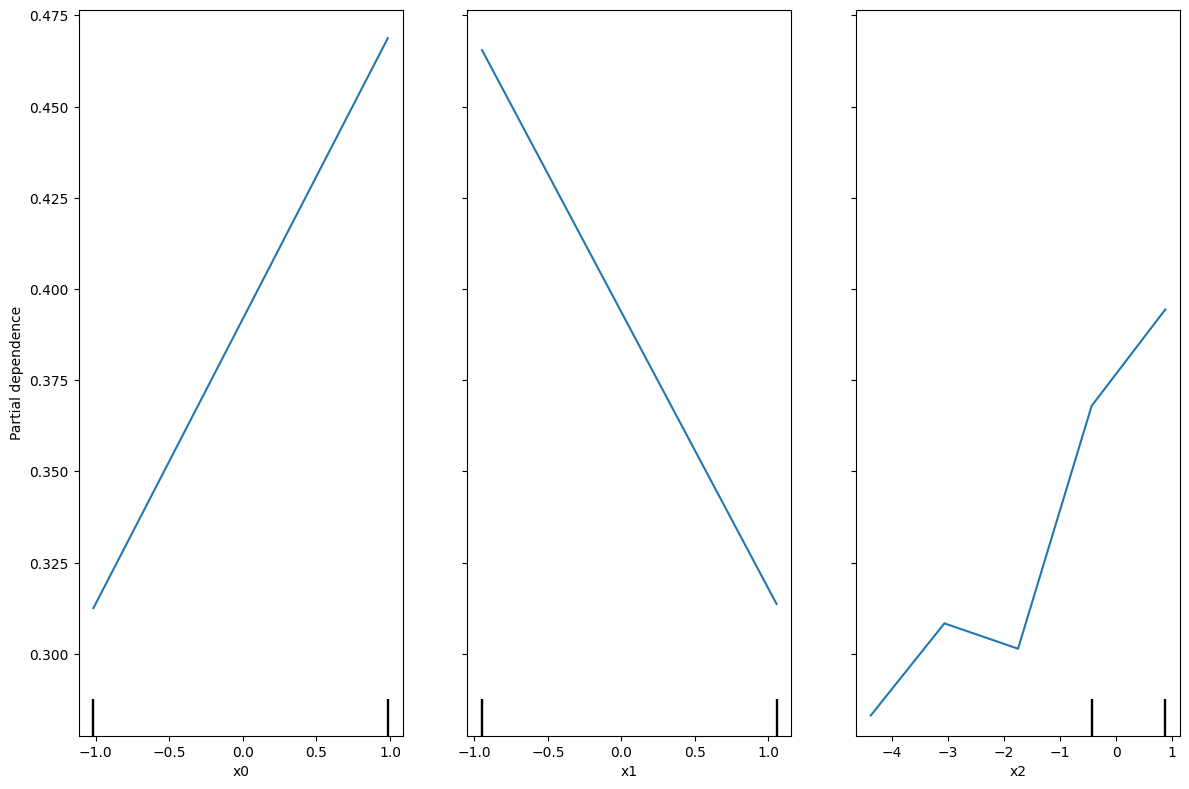

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming X and y are your features and target variable

# Select top 10 features
top_features = [
    'DEM_F_PARTYSUM_FINAL_Dem/Lean Dem', 'DEM_F_PARTYSUM_FINAL_Rep/Lean Rep',
    'DEM_F_INTFREQ', 'DEM_F_RELIG', 'DEM_F_PRAY_Seldom',
    'DEM_F_PARTY_FINAL_Other', 'DEM_F_AGECAT', 'DEM_F_INC_SDT1',
    'DEM_F_EDUCCAT2', 'DEM_F_ATTEND_Once a week'
]

X_selected = X[top_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
cm = confusion_matrix(y_test, y_pred)

# Print results
print("Random Forest Results (Top 10 Features):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: Class 0: {precision[0]:.4f}, Class 1: {precision[1]:.4f}")
print(f"Recall: Class 0: {recall[0]:.4f}, Class 1: {recall[1]:.4f}")
print(f"F1 Score: Class 0: {f1[0]:.4f}, Class 1: {f1[1]:.4f}")
print("Confusion Matrix:")
print(cm)

# Partial Dependence Plots
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf_model, X_test_scaled, [0, 1, 2], ax=ax)
plt.tight_layout()
plt.show()

Dealing with Imabalnce and Further Tuning


Results with threshold 0.3:
Accuracy: 0.6179
Precision: Class 0: 0.8442, Class 1: 0.4913
Recall: Class 0: 0.4814, Class 1: 0.8493
F1 Score: Class 0: 0.6132, Class 1: 0.6225

Results with threshold 0.4:
Accuracy: 0.6585
Precision: Class 0: 0.8166, Class 1: 0.5270
Recall: Class 0: 0.5897, Class 1: 0.7753
F1 Score: Class 0: 0.6848, Class 1: 0.6275

Results with threshold 0.5:
Accuracy: 0.6870
Precision: Class 0: 0.7853, Class 1: 0.5649
Recall: Class 0: 0.6914, Class 1: 0.6795
F1 Score: Class 0: 0.7354, Class 1: 0.6169

Results with threshold 0.6:
Accuracy: 0.6880
Precision: Class 0: 0.7328, Class 1: 0.5924
Recall: Class 0: 0.7932, Class 1: 0.5096
F1 Score: Class 0: 0.7618, Class 1: 0.5479

Results with threshold 0.7:
Accuracy: 0.6555
Precision: Class 0: 0.6675, Class 1: 0.5878
Recall: Class 0: 0.9015, Class 1: 0.2384
F1 Score: Class 0: 0.7670, Class 1: 0.3392


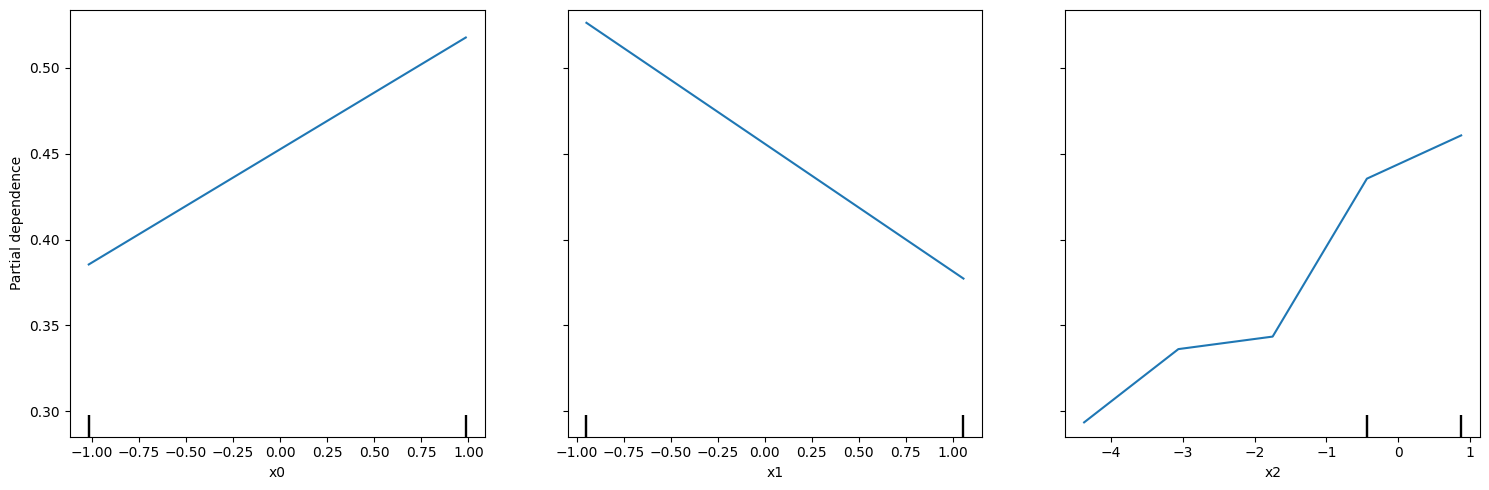

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming X and y are your features and target variable

# Select top 10 features
top_features = [
    'DEM_F_PARTYSUM_FINAL_Dem/Lean Dem', 'DEM_F_PARTYSUM_FINAL_Rep/Lean Rep',
    'DEM_F_INTFREQ', 'DEM_F_RELIG', 'DEM_F_PRAY_Seldom',
    'DEM_F_PARTY_FINAL_Other', 'DEM_F_AGECAT', 'DEM_F_INC_SDT1',
    'DEM_F_EDUCCAT2', 'DEM_F_ATTEND_Once a week'
]

X_selected = X[top_features].copy()  # Create a copy to avoid the warning

# Create interaction features
X_selected['PARTY_RELIG'] = X_selected['DEM_F_PARTYSUM_FINAL_Dem/Lean Dem'] * X_selected['DEM_F_RELIG']
X_selected['PARTY_PRAY'] = X_selected['DEM_F_PARTYSUM_FINAL_Rep/Lean Rep'] * X_selected['DEM_F_PRAY_Seldom']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model with adjusted class weights
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, 
                                  class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_proba = rf_model.predict_proba(X_test_scaled)

# Function to calculate metrics for different thresholds
def calculate_metrics(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba[:, 1] > threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    return accuracy, precision, recall, f1

# Try different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in thresholds:
    accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred_proba, threshold)
    print(f"\nResults with threshold {threshold}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: Class 0: {precision[0]:.4f}, Class 1: {precision[1]:.4f}")
    print(f"Recall: Class 0: {recall[0]:.4f}, Class 1: {recall[1]:.4f}")
    print(f"F1 Score: Class 0: {f1[0]:.4f}, Class 1: {f1[1]:.4f}")

# Partial Dependence Plots
fig, ax = plt.subplots(figsize=(15, 5))
PartialDependenceDisplay.from_estimator(rf_model, X_test_scaled, [0, 1, 2], ax=ax)
plt.tight_layout()
plt.show()

Ensemble with 0.5 Threshold

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier

# Assuming X and y are your features and target variable

# Select top 10 features
top_features = [
    'DEM_F_PARTYSUM_FINAL_Dem/Lean Dem', 'DEM_F_PARTYSUM_FINAL_Rep/Lean Rep',
    'DEM_F_INTFREQ', 'DEM_F_RELIG', 'DEM_F_PRAY_Seldom',
    'DEM_F_PARTY_FINAL_Other', 'DEM_F_AGECAT', 'DEM_F_INC_SDT1',
    'DEM_F_EDUCCAT2', 'DEM_F_ATTEND_Once a week'
]

X_selected = X[top_features].copy()

# Create interaction features
X_selected['PARTY_RELIG'] = X_selected['DEM_F_PARTYSUM_FINAL_Dem/Lean Dem'] * X_selected['DEM_F_RELIG']
X_selected['PARTY_PRAY'] = X_selected['DEM_F_PARTYSUM_FINAL_Rep/Lean Rep'] * X_selected['DEM_F_PRAY_Seldom']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models for the ensemble
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
svm_model = SVC(probability=True, random_state=42, class_weight='balanced')
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=1)

# Create the voting classifier
voting_clf = VotingClassifier(
    estimators=[('rf', rf_model), ('lr', lr_model), ('svm', svm_model), ('xgb', xgb_model)],
    voting='soft'
)

# Train the ensemble model
voting_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_proba = voting_clf.predict_proba(X_test_scaled)
y_pred = (y_pred_proba[:, 1] > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
cm = confusion_matrix(y_test, y_pred)

# Print results
print("Ensemble Model Results (threshold 0.5):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: Class 0: {precision[0]:.4f}, Class 1: {precision[1]:.4f}")
print(f"Recall: Class 0: {recall[0]:.4f}, Class 1: {recall[1]:.4f}")
print(f"F1 Score: Class 0: {f1[0]:.4f}, Class 1: {f1[1]:.4f}")
print("Confusion Matrix:")
print(cm)

# Compare with individual Random Forest model
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = (rf_model.predict_proba(X_test_scaled)[:, 1] > 0.5).astype(int)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average=None)
recall_rf = recall_score(y_test, y_pred_rf, average=None)
f1_rf = f1_score(y_test, y_pred_rf, average=None)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("\nRandom Forest Results (threshold 0.5):")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: Class 0: {precision_rf[0]:.4f}, Class 1: {precision_rf[1]:.4f}")
print(f"Recall: Class 0: {recall_rf[0]:.4f}, Class 1: {recall_rf[1]:.4f}")
print(f"F1 Score: Class 0: {f1_rf[0]:.4f}, Class 1: {f1_rf[1]:.4f}")
print("Confusion Matrix:")
print(cm_rf)

Ensemble Model Results (threshold 0.5):
Accuracy: 0.6941
Precision: Class 0: 0.7870, Class 1: 0.5744
Recall: Class 0: 0.7044, Class 1: 0.6767
F1 Score: Class 0: 0.7434, Class 1: 0.6214
Confusion Matrix:
[[436 183]
 [118 247]]

Random Forest Results (threshold 0.5):
Accuracy: 0.6870
Precision: Class 0: 0.7853, Class 1: 0.5649
Recall: Class 0: 0.6914, Class 1: 0.6795
F1 Score: Class 0: 0.7354, Class 1: 0.6169
Confusion Matrix:
[[428 191]
 [117 248]]


Final Model

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import randint, uniform

# Assuming X_selected and y are your features and target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter distributions for each model
rf_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

gb_params = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

# Define base models
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# Perform RandomizedSearchCV for each model
rf_search = RandomizedSearchCV(rf_model, rf_params, n_iter=20, cv=3, random_state=42, n_jobs=-1)
gb_search = RandomizedSearchCV(gb_model, gb_params, n_iter=20, cv=3, random_state=42, n_jobs=-1)

# Fit the searches
rf_search.fit(X_train_scaled, y_train)
gb_search.fit(X_train_scaled, y_train)

# Create the voting classifier with optimized models
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_search.best_estimator_),
        ('gb', gb_search.best_estimator_)
    ],
    voting='soft'
)

# Train the ensemble model
voting_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_proba = voting_clf.predict_proba(X_test_scaled)
y_pred = (y_pred_proba[:, 1] > 0.3).astype(int)  # Changed threshold to 0.3

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
cm = confusion_matrix(y_test, y_pred)

# Print results
print("Ensemble Model Results with Hyperparameter Tuning (threshold 0.3):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: Class 0: {precision[0]:.4f}, Class 1: {precision[1]:.4f}")
print(f"Recall: Class 0: {recall[0]:.4f}, Class 1: {recall[1]:.4f}")
print(f"F1 Score: Class 0: {f1[0]:.4f}, Class 1: {f1[1]:.4f}")
print("Confusion Matrix:")
print(cm)

Ensemble Model Results with Hyperparameter Tuning (threshold 0.3):
Accuracy: 0.6677
Precision: Class 0: 0.8364, Class 1: 0.5345
Recall: Class 0: 0.5864, Class 1: 0.8055
F1 Score: Class 0: 0.6895, Class 1: 0.6426
Confusion Matrix:
[[363 256]
 [ 71 294]]


AI Sentiment Analysis with Natural Language Processing

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Numan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Numan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Numan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Numan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Topic 1:
human refuse loss job quality connection better life society make
Topic 2:
reliant people refuse efficient save time task handle mundane tedious
Topic 3:
refuse digital hacking privacy surveillance people misusing outsmarting powerful future
Topic 4:
mistake fails make refuse consequenceseffects unforeseen regulation oversight scifi based
Topic 5:
answer knowno dont help worklabor exciting interesting refuse disability anecdote
+----+-------------+-----------+
|    |   sentiment |   cluster |
+====+=============+===========+
|  0 |      0      |         0 |
+----+-------------+-----------+
|  1 |      0.2235 |         3 |
+----+-------------+-----------+
|  2 |      0      |         0 |
+----+-------------+-----------+
|  3 |      0      |         0 |
+----+-------------+-----------+
|  4 |      0      |         0 |
+----+-------------+-----------+


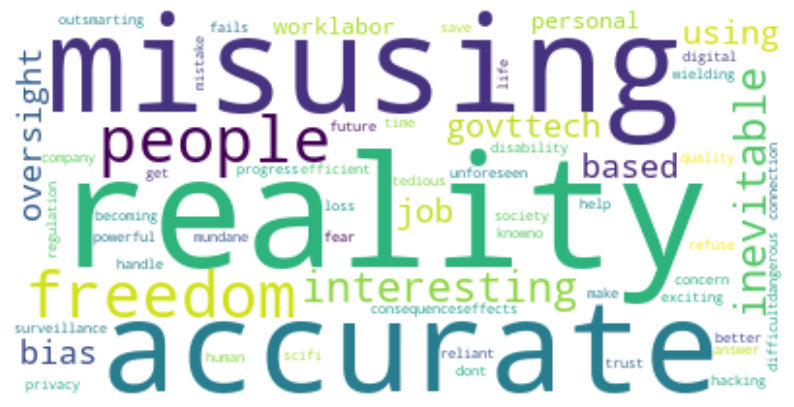

In [15]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from tabulate import tabulate
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Read data file
df = pd.read_csv("https://raw.githubusercontent.com/NumanESchulich/SchulichDataScience/main/AI%20Fundamentals%20(MMAI%205000S)/AI-Human%20Pew%20Data.csv")

# Specify the columns to analyze
columns_to_analyze = [
    'EXCITEOE_W99_OE1', 'EXCITEOE_W99_OE2', 'EXCITEOE_W99_OE3',
    'EXCITEOE_REFUSED_W99', 'CONCERNOE_W99_OE1', 'CONCERNOE_W99_OE2',
    'CONCERNOE_W99_OE3', 'CONCERNOE_REFUSED_W99'
]

# Combine text data from all specified columns into a single series
text_data = df[columns_to_analyze].astype(str).apply(lambda x: ' '.join(x), axis=1)

# Define custom stopwords
custom_stopwords = set(stopwords.words('english') + ['coded', 'have', 'ai', 'anecdote', 'lack', 'task', 'aitech', 'elderlyhave', 'tech', 'nan', 'asked', 'refused'])

# Preprocess the text
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in custom_stopwords]
    # Lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

preprocessed_text = text_data.apply(preprocess_text)

# Ensure unique words for word cloud
wordcloud_text = ' '.join(set(' '.join(preprocessed_text).split()))

# Sentiment Analysis
sid = SentimentIntensityAnalyzer()
df['sentiment'] = preprocessed_text.apply(lambda x: sid.polarity_scores(x)['compound'])

# Topic Modeling
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(preprocessed_text)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, no_top_words)

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(tfidf)
df['cluster'] = kmeans.labels_

# Display the processed DataFrame using tabulate
print(tabulate(df[['sentiment', 'cluster']].head(), headers='keys', tablefmt='grid'))

# Generate and display word cloud
wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white', max_words=100).generate(wordcloud_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
